In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = 'cs231n/assignments/assignment4/challenges-in-representation-learning-facial-expression-recognition-challenge'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment4/challenges-in-representation-learning-facial-expression-recognition-challenge


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

!pip install wandb -q
import wandb
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_csv('train.csv')
print(f"Training data shape: {train_df.shape}")
print(f"Columns: {train_df.columns.tolist()}")
print(f"Emotion distribution:")
print(train_df['emotion'].value_counts().sort_index())

Training data shape: (28709, 2)
Columns: ['emotion', 'pixels']
Emotion distribution:
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64


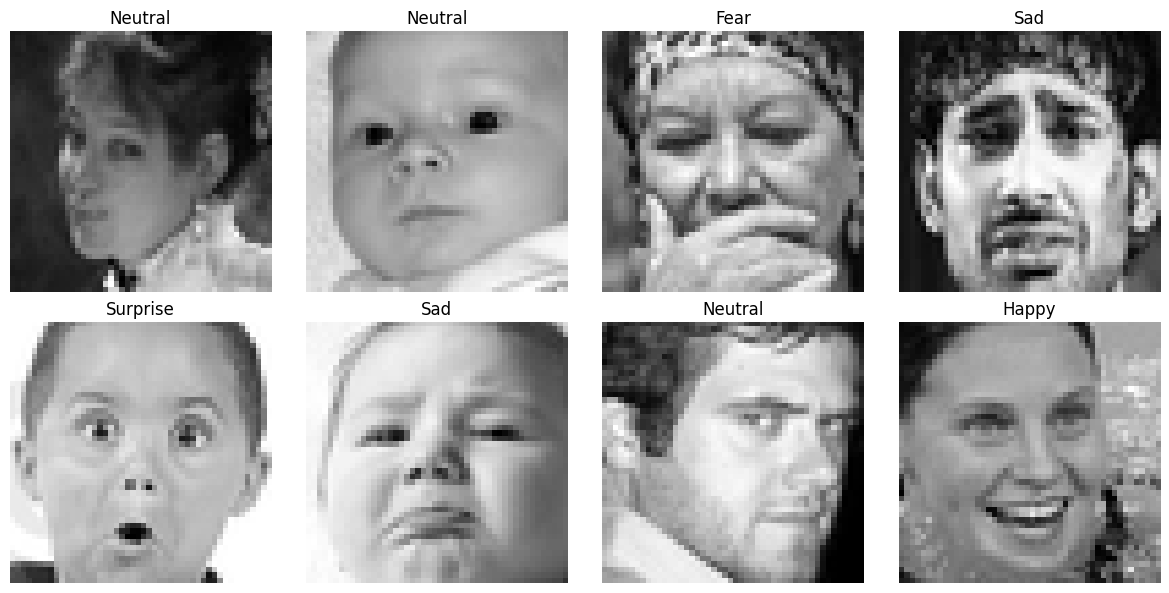

In [3]:
def show_sample_images(df, n_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
                     4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

    for i in range(n_samples):
        idx = np.random.randint(0, len(df))
        pixels = np.array([int(pixel) for pixel in df.iloc[idx]['pixels'].split()]).reshape(48, 48)
        emotion = df.iloc[idx]['emotion']

        axes[i].imshow(pixels, cmap='gray')
        axes[i].set_title(f'{emotion_labels[emotion]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_sample_images(train_df)

In [4]:
from google.colab import userdata
wandb_api_key = userdata.get('wandb_api')
assert wandb_api_key is not None, "wandb_api_key not found in secrets!"

wandb.login(key=wandb_api_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gmode (gmode-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(48, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
class FERDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pixels = np.array([int(p) for p in self.df.iloc[idx]['pixels'].split()], dtype=np.uint8).reshape(48, 48)
        image = pixels.astype(np.uint8)
        label = int(self.df.iloc[idx]['emotion'])

        if self.transform:
            image = self.transform(image)

        return image, label


In [7]:
class BetterCNN(nn.Module):
    def __init__(self):
        super(BetterCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 7)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.classifier(self.features(x))


In [8]:
train_data, val_data = train_test_split(train_df, test_size=0.1, stratify=train_df['emotion'], random_state=42)

train_dataset = FERDataset(train_data, transform=train_transform)
val_dataset = FERDataset(val_data, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BetterCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

wandb.init(project="fer-challenge", name="better-cnn", config={
    "model": "BetterCNN",
    "epochs": 10,
    "batch_size": 64,
    "lr": 1e-3,
    "optimizer": "Adam",
    "weight_init": "kaiming",
    "augmentation": True,
    "batch_norm": True
})


In [10]:
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)
        wandb.log({"train_loss": total_loss / len(train_loader), "train_acc": train_acc})

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        wandb.log({"val_loss": val_loss / len(val_loader), "val_acc": val_acc})

        print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

train_model(model, train_loader, val_loader, epochs=10)


100%|██████████| 404/404 [04:24<00:00,  1.53it/s]


Epoch 1: Train Acc=0.3495, Val Acc=0.4476


100%|██████████| 404/404 [04:23<00:00,  1.53it/s]


Epoch 2: Train Acc=0.4538, Val Acc=0.5082


100%|██████████| 404/404 [04:16<00:00,  1.57it/s]


Epoch 3: Train Acc=0.4925, Val Acc=0.5475


100%|██████████| 404/404 [04:25<00:00,  1.52it/s]


Epoch 4: Train Acc=0.5170, Val Acc=0.5573


100%|██████████| 404/404 [04:20<00:00,  1.55it/s]


Epoch 5: Train Acc=0.5334, Val Acc=0.5709


100%|██████████| 404/404 [04:21<00:00,  1.54it/s]


Epoch 6: Train Acc=0.5465, Val Acc=0.5817


100%|██████████| 404/404 [04:19<00:00,  1.55it/s]


Epoch 7: Train Acc=0.5593, Val Acc=0.5859


100%|██████████| 404/404 [04:17<00:00,  1.57it/s]


Epoch 8: Train Acc=0.5680, Val Acc=0.5932


100%|██████████| 404/404 [04:22<00:00,  1.54it/s]


Epoch 9: Train Acc=0.5740, Val Acc=0.6088


100%|██████████| 404/404 [04:16<00:00,  1.58it/s]


Epoch 10: Train Acc=0.5824, Val Acc=0.6071


In [11]:
train_model(model, train_loader, val_loader, epochs=20)

100%|██████████| 404/404 [04:23<00:00,  1.53it/s]


Epoch 1: Train Acc=0.5906, Val Acc=0.6116


100%|██████████| 404/404 [04:20<00:00,  1.55it/s]


Epoch 2: Train Acc=0.5995, Val Acc=0.6120


100%|██████████| 404/404 [04:17<00:00,  1.57it/s]


Epoch 3: Train Acc=0.6035, Val Acc=0.6120


100%|██████████| 404/404 [04:19<00:00,  1.56it/s]


Epoch 4: Train Acc=0.6144, Val Acc=0.6141


100%|██████████| 404/404 [04:15<00:00,  1.58it/s]


Epoch 5: Train Acc=0.6151, Val Acc=0.6273


100%|██████████| 404/404 [04:18<00:00,  1.56it/s]


Epoch 6: Train Acc=0.6182, Val Acc=0.6287


100%|██████████| 404/404 [04:17<00:00,  1.57it/s]


Epoch 7: Train Acc=0.6263, Val Acc=0.6200


100%|██████████| 404/404 [04:10<00:00,  1.61it/s]


Epoch 8: Train Acc=0.6342, Val Acc=0.6134


100%|██████████| 404/404 [04:13<00:00,  1.59it/s]


Epoch 9: Train Acc=0.6351, Val Acc=0.6364


100%|██████████| 404/404 [04:11<00:00,  1.61it/s]


Epoch 10: Train Acc=0.6440, Val Acc=0.6214


100%|██████████| 404/404 [04:09<00:00,  1.62it/s]


Epoch 11: Train Acc=0.6498, Val Acc=0.6353


100%|██████████| 404/404 [04:09<00:00,  1.62it/s]


Epoch 12: Train Acc=0.6475, Val Acc=0.6315


100%|██████████| 404/404 [04:08<00:00,  1.63it/s]


Epoch 13: Train Acc=0.6568, Val Acc=0.6440


100%|██████████| 404/404 [04:06<00:00,  1.64it/s]


Epoch 14: Train Acc=0.6574, Val Acc=0.6433


100%|██████████| 404/404 [04:02<00:00,  1.67it/s]


Epoch 15: Train Acc=0.6624, Val Acc=0.6395


100%|██████████| 404/404 [04:05<00:00,  1.65it/s]


Epoch 16: Train Acc=0.6665, Val Acc=0.6468


100%|██████████| 404/404 [04:05<00:00,  1.64it/s]


Epoch 17: Train Acc=0.6671, Val Acc=0.6465


100%|██████████| 404/404 [04:07<00:00,  1.63it/s]


Epoch 18: Train Acc=0.6754, Val Acc=0.6482


100%|██████████| 404/404 [04:05<00:00,  1.64it/s]


Epoch 19: Train Acc=0.6795, Val Acc=0.6325


100%|██████████| 404/404 [04:08<00:00,  1.62it/s]


Epoch 20: Train Acc=0.6805, Val Acc=0.6419
